We are dealing with Network Intrusion Detection System (IDS) on DDOS using autoencoder and Light Gradient Boosting Machine KDD99 dataset

In [29]:
import pandas as pd
import os, io, requests
import numpy as np
from sklearn import metrics
from sklearn.metrics import *
import seaborn as sns
import datetime as dt
from sklearn import preprocessing
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import get_file
# We download 10% of the KDD99 dataset sicne it is over a few million records
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise
    
print(path) 

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv(path, names=[
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome']
)
df

/Users/tomxu/.keras/datasets/kddcup.data_10_percent.gz


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [30]:
def df_character(df):
    print("Read {} rows.".format(len(df)))
    print('='*40)
    print('The number of data points are:', df.shape[0])
    print('='*40)
    print('The number of features are:', df.shape[1])
    print('='*40)
    output = df['outcome'].values
    labels = set(output)
    print('The different type of output labels are:', labels)
    print('='*125)
    print('The number of different output labels are:', len(labels))
df_character(df)

Read 494021 rows.
The number of data points are: 494021
The number of features are: 42
The different type of output labels are: {'rootkit.', 'land.', 'phf.', 'satan.', 'portsweep.', 'neptune.', 'buffer_overflow.', 'back.', 'nmap.', 'warezclient.', 'ftp_write.', 'warezmaster.', 'pod.', 'normal.', 'guess_passwd.', 'multihop.', 'smurf.', 'imap.', 'teardrop.', 'perl.', 'ipsweep.', 'loadmodule.', 'spy.'}
The number of different output labels are: 23


In [31]:
# we can compare output labels with what is supplied: "training_attack_types":
with open("./training_attack_types",'r') as attacks:
    print(attacks.read())

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l




In [32]:
df["outcome"].value_counts()

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: outcome, dtype: int64

In [33]:
attacks_types = {
    'normal': 'normal',
'back': 'dos',
'buffer_overflow': 'u2r',
'ftp_write': 'r2l',
'guess_passwd': 'r2l',
'imap': 'r2l',
'ipsweep': 'probe',
'land': 'dos',
'loadmodule': 'u2r',
'multihop': 'r2l',
'neptune': 'dos',
'nmap': 'probe',
'perl': 'u2r',
'phf': 'r2l',
'pod': 'dos',
'portsweep': 'probe',
'rootkit': 'u2r',
'satan': 'probe',
'smurf': 'dos',
'spy': 'r2l',
'teardrop': 'dos',
'warezclient': 'r2l',
'warezmaster': 'r2l',
}

In [34]:
df['Attack Type'] = df.outcome.apply(lambda r: attacks_types[r[:-1]])
df['Attack Type'].value_counts()

dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: Attack Type, dtype: int64

The KDD 99 dataset includes non-numerical features and duplicates, so this dataset is preprocessed before being inputted into models.
Firstly, the data are deduplicated and disambiguated. Because these duplicate data cause that the model assign a bigger weight to the more frequent data. We need to ensure that there is only one result for a piece of data, these data are disambiguated. After this work, the training dataset consists of 145585 samples and test dataset consists of 77291 samples.
Then, data transformation is applied to the experiment. The symbolic features (protocol_type, services and flag) are mapped to numeric feature by One-Hot Encoding (Buckman et al., 2018). For example, the feature ‘protocol_type’ contains three values: tcp, udp and icmp. These values are mapped to (1, 0, 0), (0, 1, 0) and (0, 0, 1) in turn. However, the label is mapped to numeric feature by Label- Encoding (Zhang et al., 2018). As we have seen in Table 1, the ‘label’ field contains five values, which are mapped to 0, 1, 2, 3 and 4 from top to bottom.
Since Auto-Encoder is used in the framework, it is necessary to standardize the data to eliminate differences caused by the different value scales between features. In this experiment, z-score method is adopted. The standard score of a raw score is calculated as 𝑧=(𝑥 − 𝜇)/𝜎
where 𝜇 is the mean of population and 𝜎 is the
standard deviation of the population.

In [35]:
# Data Cleaning
def eda(df):
    # Checking for NULL values
    print('Null values in dataset are',len(df[df.isnull().any(1)]))
    print('='*40)
    print("Read {} rows.".format(len(df)))
    # Checkng for DUPLICATE values
    df.drop_duplicates(keep='first', inplace = True)
    # For now, just drop NA's (rows with missing values)
    df.dropna(inplace=True,axis=1) 
    # stored the data into a pickle file so we can load through
    # df.to_pickle('df.pkl')
    print("Read {} rows.".format(len(df)))
eda(df)

Null values in dataset are 0
Read 494021 rows.
Read 145586 rows.


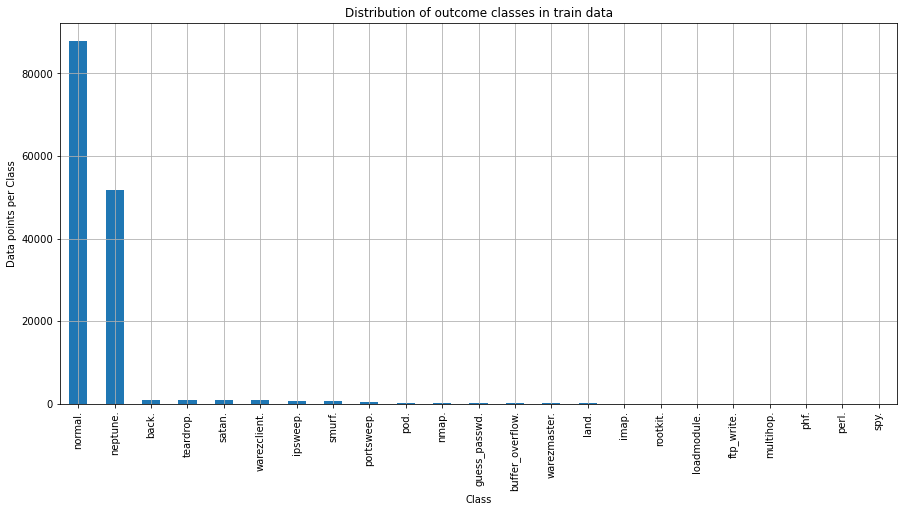

In [36]:
# EDA
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
def eda_plot(df):
    plt.figure(figsize=(15,7))
    class_distribution = df['outcome'].value_counts()
    class_distribution.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    plt.title('Distribution of outcome classes in train data')
    plt.grid()
    plt.show()
eda_plot(df)

In [32]:
sorted_yi = np.argsort(-class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')
    
#df.groupby('outcome')['outcome'].count() #this could also be used if you want no-fromatted for above.

Number of data points in class normal. : 87832 ( 60.33 %)
Number of data points in class neptune. : 51820 ( 35.594 %)
Number of data points in class back. : 968 ( 0.665 %)
Number of data points in class teardrop. : 918 ( 0.631 %)
Number of data points in class satan. : 906 ( 0.622 %)
Number of data points in class warezclient. : 893 ( 0.613 %)
Number of data points in class ipsweep. : 651 ( 0.447 %)
Number of data points in class smurf. : 641 ( 0.44 %)
Number of data points in class portsweep. : 416 ( 0.286 %)
Number of data points in class pod. : 206 ( 0.141 %)
Number of data points in class nmap. : 158 ( 0.109 %)
Number of data points in class guess_passwd. : 53 ( 0.036 %)
Number of data points in class buffer_overflow. : 30 ( 0.021 %)
Number of data points in class warezmaster. : 20 ( 0.014 %)
Number of data points in class land. : 19 ( 0.013 %)
Number of data points in class imap. : 12 ( 0.008 %)
Number of data points in class rootkit. : 10 ( 0.007 %)
Number of data points in class

In [27]:
ENCODING = 'utf-8'

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [48]:
#Encode the feature vector

# Encode a numeric column as zscores so they are automatically scaled
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean(axis=0)
    if sd is None:
        sd = df[name].std(axis=0)
    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue), similar to ohe
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Now encode the feature vector

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]
# This is the numeric feature vector, as it goes to the neural net

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.10785,-0.004293,0.042595,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
1,-0.10785,-0.004261,-0.039036,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
2,-0.10785,-0.004263,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
3,-0.10785,-0.004272,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
4,-0.10785,-0.004273,-0.013613,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0


In [38]:
# Convert to numpy - Classification based on detailed labels(sub-category)
def convert2numpy(df):
    x_columns = df.columns.drop(['outcome', 'Attack Type'])
    x = df[x_columns].values # features matrix
    dummies = pd.get_dummies(df['outcome']) # encoded label df
    outcomes = dummies.columns
    num_classes = len(outcomes)
    y = dummies.values # encoded label matrix
    return (x, y)
x = convert2numpy(df)[0]
y = convert2numpy(df)[1]

In [39]:
# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=19)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/19


2021-10-19 16:18:12.351319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-19 16:18:12.351409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-10-19 16:18:12.414949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-19 16:18:12.415119: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-19 16:18:12.529369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-19 16:18:26.729120: I tensorflow/core/grappler/

3413/3413 - 17s - loss: 0.4227 - val_loss: 0.1671
Epoch 2/19
3413/3413 - 17s - loss: 0.1241 - val_loss: 0.1031
Epoch 3/19
3413/3413 - 17s - loss: 0.0926 - val_loss: 0.0825
Epoch 4/19
3413/3413 - 17s - loss: 0.0859 - val_loss: 0.0780
Epoch 5/19
3413/3413 - 17s - loss: 0.0725 - val_loss: 0.0727
Epoch 6/19
3413/3413 - 17s - loss: 0.0691 - val_loss: 0.0704
Epoch 7/19
3413/3413 - 17s - loss: 0.0748 - val_loss: 0.0650
Epoch 8/19
3413/3413 - 17s - loss: 0.0672 - val_loss: 0.0598
Epoch 9/19
3413/3413 - 17s - loss: 0.0622 - val_loss: 0.0590
Epoch 10/19
3413/3413 - 17s - loss: 0.0601 - val_loss: 0.0559
Epoch 11/19
3413/3413 - 17s - loss: 0.0556 - val_loss: 0.0540
Epoch 12/19
3413/3413 - 17s - loss: 0.0611 - val_loss: 0.0554
Epoch 13/19
3413/3413 - 17s - loss: 0.0549 - val_loss: 0.0529
Epoch 14/19
3413/3413 - 17s - loss: 0.0531 - val_loss: 0.0566
Epoch 15/19
3413/3413 - 17s - loss: 0.0548 - val_loss: 0.0545
Epoch 16/19
3413/3413 - 17s - loss: 0.0502 - val_loss: 0.0531
Epoch 17/19
3413/3413 - 17s 

In [40]:
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('='*50)
model.summary()

Learning Rate - 
0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1210      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_4 (Dense)              (None, 23)                46        
Total params: 2,327
Trainable params: 2,327
Non-trainable params: 0
_________________________________________________________________


In [42]:
def confusion_matrix_func(y_test, y_test_pred):    
    '''
    This function computes the confusion matrix using Predicted and Actual values and plots 
    a confusion matrix heatmap for detailed sub-category labels of attack
    '''
    C = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(C)
    labels = ['back', 'butter_overflow', 'loadmodule', 'guess_passwd', 'imap', 'ipsweep', 'warezmaster', 'rootkit', 
'multihop', 'neptune', 'nmap', 'normal', 'phf', 'perl', 'pod', 'portsweep', 'ftp_write', 'satan', 'smurf', 'teardrop', 'warezclient', 'land']
    plt.figure(figsize=(20,15))
    sns.set(font_scale=1.4)
    sns.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')    
    plt.show()

# calculate roc curve
#fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, pred)

def multiclass_roc_auc_score(y_test, pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    pred = lb.transform(pred)
    return roc_auc_score(y_test, pred, average=average)

print('Train data')
print(x_train.shape)
print(y_train.shape)
print('='*20)
print('Test data')
print(x_test.shape)
print(y_test.shape)
print('='*20)

# Measure accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
print('Predicting on the test data:')
start = dt.datetime.now()
escore = model.evaluate(x_test, y_test, batch_size=32)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)

vscore = metrics.accuracy_score(y_eval, pred)

rscore = recall_score(y_eval, pred, average='weighted')

ascore = precision_score(y_eval, pred, average='weighted')

f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

roc_auc_socre = multiclass_roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)
print('='*50)
print("Validation score: {}".format(vscore))
print('='*50)
print("Evaluation score: {}".format(escore))
print('='*50)
print("Recall score: {}".format(rscore))
print('='*50)
print("Precision score: {}".format(ascore))
print('='*50)
print("F1 score: {}".format(f1score))
print('='*50)
print("ROC-AUC score: {}".format(roc_auc_socre))

Train data
(109189, 120)
(109189, 23)
Test data
(36397, 120)
(36397, 23)
Predicting on the test data:
1138/1138 [==============================] - 4s 3ms/step - loss: 0.0485
Completed
Time taken: 0:00:05.224932
Validation score: 0.9909882682638679
Evaluation score: 0.04845375195145607
Recall score: 0.9909882682638679
Precision score: 0.98599322813586
F1 score: 0.9881492235884367
ROC-AUC score: 0.6841643840339747


/Users/tomxu/miniforge3/envs/tf2.5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


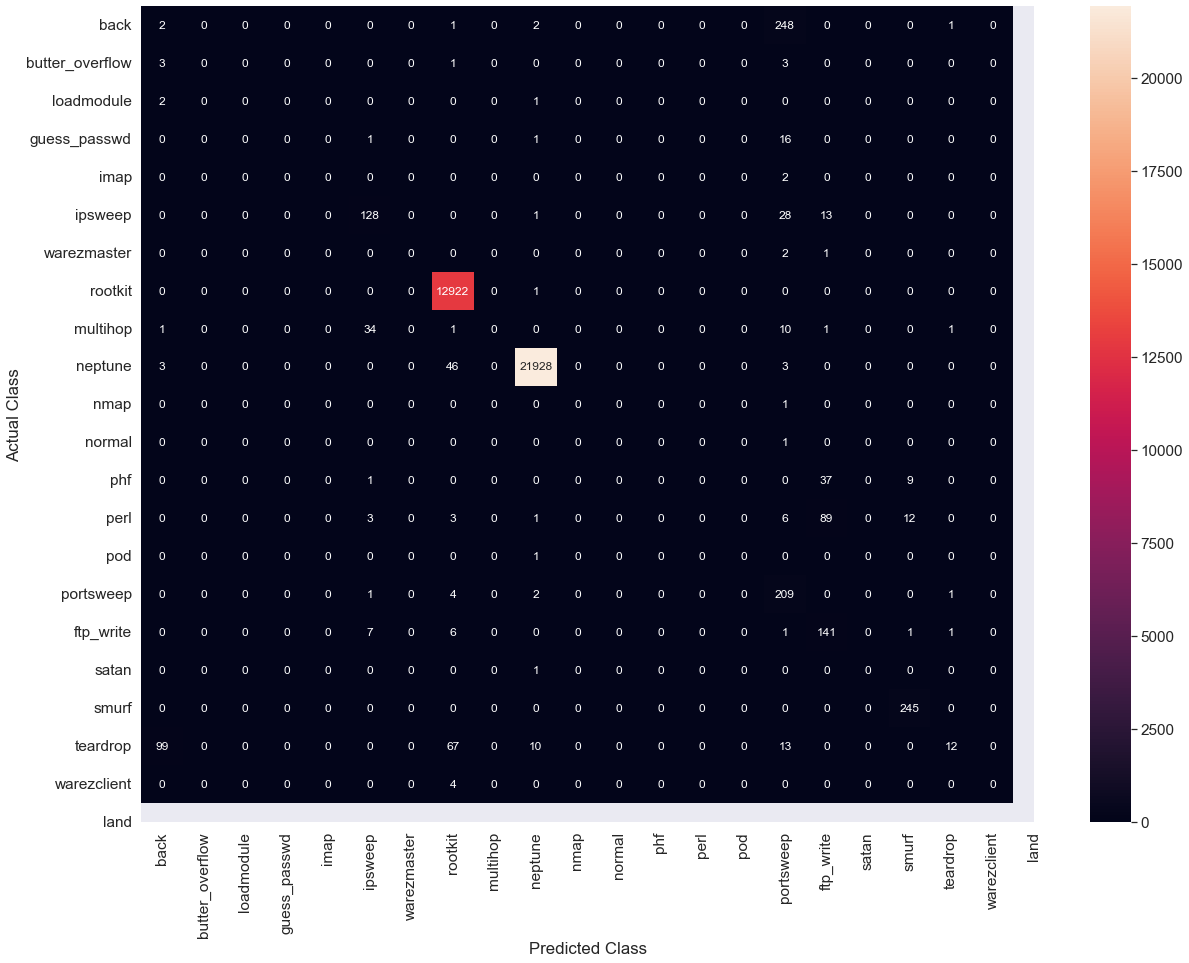

In [44]:
confusion_matrix_func(y_eval, pred)

In [85]:
# The following is using attack types (including normal = 5) as labels
def convert2numpy_type(df):
    x_columns = df.columns.drop(['outcome', 'Attack Type'])
    x = df[x_columns].values # features matrix
    dummies1 = df[['Attack Type']] # encoded label df
    outcomes1 = dummies1.columns
    num_classes1 = len(outcomes1)
    z = dummies1.values.ravel() # encoded label matrix        
    return x, z
X_train, X_test = convert2numpy_type(df)
# X_train, X_test, Z_train, Z_test = train_test_split(x, z, test_size=0.25, random_state=42)
# print(X_train.shape, X_test.shape)
# print(Z_train.shape, Z_test.shape)
print(X_train.shape, X_test.shape)

(145586, 120) (145586,)


Within the folder of the updated dataset, The new test set `corrected` is actually labelled test set that contains 311029 rows of labeled data.

In [44]:
df_test = pd.read_csv("./corrected", names=[
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome']
)
df_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
3,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311024,0,udp,private,SF,105,147,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.
311025,0,udp,private,SF,105,147,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.
311026,0,udp,private,SF,105,147,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.
311027,0,udp,private,SF,105,147,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.


In [45]:
df_character(df_test)

Read 311029 rows.
The number of data points are: 311029
The number of features are: 42
The different type of output labels are: {'rootkit.', 'mscan.', 'sendmail.', 'land.', 'phf.', 'satan.', 'named.', 'portsweep.', 'neptune.', 'buffer_overflow.', 'httptunnel.', 'back.', 'xlock.', 'mailbomb.', 'nmap.', 'ftp_write.', 'apache2.', 'warezmaster.', 'pod.', 'normal.', 'guess_passwd.', 'multihop.', 'snmpgetattack.', 'worm.', 'sqlattack.', 'snmpguess.', 'smurf.', 'imap.', 'teardrop.', 'processtable.', 'perl.', 'saint.', 'xterm.', 'ps.', 'ipsweep.', 'udpstorm.', 'loadmodule.', 'xsnoop.'}
The number of different output labels are: 38


The unique output labels number is 38 in this corrected test set, much higher than the 23 in the training set.

In [46]:
df_test["outcome"].value_counts()

smurf.              164091
normal.              60593
neptune.             58001
snmpgetattack.        7741
mailbomb.             5000
guess_passwd.         4367
snmpguess.            2406
satan.                1633
warezmaster.          1602
back.                 1098
mscan.                1053
apache2.               794
processtable.          759
saint.                 736
portsweep.             354
ipsweep.               306
httptunnel.            158
pod.                    87
nmap.                   84
buffer_overflow.        22
multihop.               18
named.                  17
sendmail.               17
ps.                     16
rootkit.                13
xterm.                  13
teardrop.               12
xlock.                   9
land.                    9
xsnoop.                  4
ftp_write.               3
loadmodule.              2
perl.                    2
udpstorm.                2
worm.                    2
phf.                     2
sqlattack.               2
i

Null values in dataset are 0
Read 311029 rows.
Read 77291 rows.


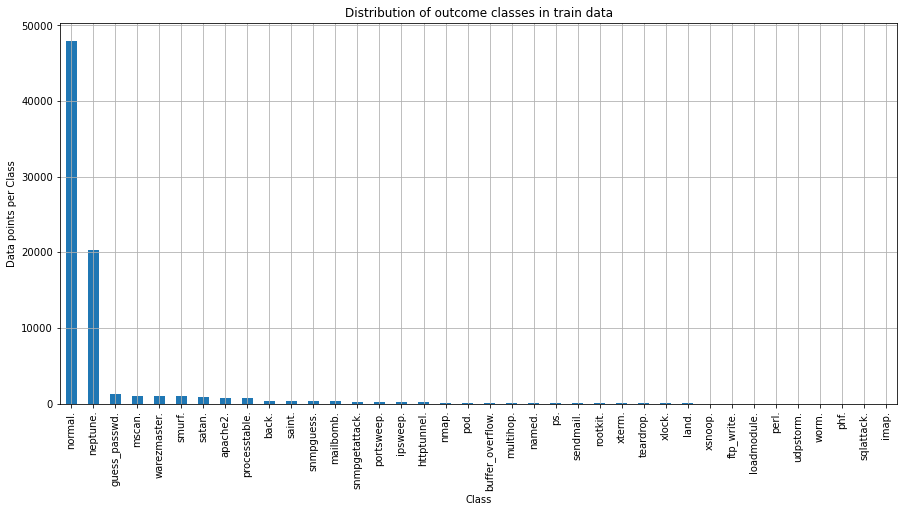

In [47]:
# Now we add those sub-category labels unique only to test dataset
test_attacks_types = {
'normal': 'normal',
'apache2': 'dos',
'back': 'dos',
'buffer_overflow': 'u2r',
'ftp_write': 'r2l',
'guess_passwd': 'r2l',
'httptunnel': 'r2l',
'imap': 'r2l',
'ipsweep': 'probe',
'land': 'dos',
'loadmodule': 'u2r',
'mailbomb': 'dos',
'mscan': 'probe',
'multihop': 'r2l',
'named': 'r2l',
'neptune': 'dos',
'nmap': 'probe',
'perl': 'u2r',
'phf': 'r2l',
'pod': 'dos',
'portsweep': 'probe',
'processtable': 'dos',
'ps': 'u2r',
'rootkit': 'u2r',
'saint': 'probe',
'satan': 'probe',
'sendmail': 'r2l',
'smurf': 'dos',
'snmpgetattack': 'r2l',
'snmpguess': 'r2l',
'spy': 'r2l',
'sqlattack': 'u2r',
'teardrop': 'dos',
'udpstorm': 'dos',
'warezclient': 'r2l',
'warezmaster': 'r2l',
'worm': 'dos',
'xterm': 'u2r',
'xlock': 'r2l',
'xsnoop': 'r2l',
}
df_test['Attack Type'] = df_test.outcome.apply(lambda r: test_attacks_types[r[:-1]])
df_test['Attack Type'].value_counts()
eda(df_test)
eda_plot(df_test)

In [49]:
feature_encoding(df_test)
df_test[0:5]
# This is the numeric feature vector for the test df, as it goes to the neural net

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_host_login-1,is_guest_login-0,is_guest_login-1
0,-0.086793,-0.013008,-0.084544,-0.032676,-0.010508,-0.067479,-0.077925,-0.009185,-0.028334,-0.007592,...,1,0,1,0,1,0,1,0,1,0
3,-0.086793,-0.013008,-0.084544,-0.032676,-0.010508,-0.067479,-0.077925,-0.009185,-0.028334,-0.007592,...,1,0,1,0,1,0,1,0,1,0
4,-0.086793,-0.013008,-0.084544,-0.032676,-0.010508,-0.067479,-0.077925,-0.009185,-0.028334,-0.007592,...,1,0,1,0,1,0,1,0,1,0
5,-0.086793,-0.013008,-0.084544,-0.032676,-0.010508,-0.067479,-0.077925,-0.009185,-0.028334,-0.007592,...,1,0,1,0,1,0,1,0,1,0
6,-0.086793,-0.013305,-0.089074,-0.032676,-0.010508,-0.067479,-0.077925,-0.009185,-0.028334,-0.007592,...,1,0,1,0,1,0,1,0,1,0


In [86]:
# Let us look at the corrected test dataset including the inputs and outputs
Y_train, Y_test = convert2numpy_type(df_test)
print(Y_train.shape, Y_test.shape)

(77291, 120) (77291,)


In [87]:
# we could also make a model for category or type of attacks using decision tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier(criterion="entropy", max_depth = 2)
model.fit(X_train, X_test)
Y_test_pred = model.predict(Y_train)
print("Training Accuracy Score:", model.score(X_train, X_test))
print("Test Accuracy Score:", accuracy_score(Y_test, Y_test_pred))

Training Accuracy Score: 0.9564243814652508
Test Accuracy Score: 0.8981899574335951


In [112]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(n_estimators=10)
model1.fit(X_train, X_test)
Y_test_pred1 = model1.predict(Y_train)
print("Training Score:", model1.score(X_train, X_test))
print("Test Score:", accuracy_score(Y_test, Y_test_pred1))

Training Score: 0.9999931312076711
Test Score: 0.7019575371000505


In [113]:
from sklearn.svm import SVC
model2 = SVC(gamma = 'scale')
model2.fit(X_train, X_test)
Y_test_pred2 = model2.predict(Y_train)
print("Train score is:", model2.score(X_train, X_test))
print("Test score is:", accuracy_score(Y_test,Y_test_pred2))

Train score is: 0.9984476529336612
Test score is: 0.9238591815347195


In [115]:
from sklearn.linear_model import LogisticRegression
model3 = LogisticRegression(max_iter=6000)
model3.fit(X_train, X_test)
Y_test_pred3 = model3.predict(Y_train)
print("Train score is:", model3.score(X_train, X_test))
print("Test score is:", accuracy_score(Y_test_pred3,Y_test))

Train score is: 0.997135713598835
Test score is: 0.7113376719152295


In [116]:
from sklearn.ensemble import GradientBoostingClassifier
model4 = GradientBoostingClassifier(random_state=0)
model4.fit(X_train, X_test)
Y_test_pred4 = model4.predict(Y_train)
print("Train score is:", model4.score(X_train, X_test))
print("Test score is:", accuracy_score(Y_test_pred4,Y_test))

Train score is: 0.9988941244350419
Test score is: 0.9043873154701065


In [117]:
# xgboost for classification
from xgboost import XGBClassifier
from numpy import asarray
# evaluate the model
xgb_cls = XGBClassifier(random_state=0)
# fit the model on the training data
xgb_cls.fit(X_train, X_test)
# make a single prediction
yhat = xgb_cls.predict(Y_train)
acc = accuracy_score(yhat, Y_test)
print("Train score is:", xgb_cls.score(X_train, X_test))
print("The accuracy score (acc) on test set: {:.4f}".format(acc))

/Users/tomxu/miniforge3/envs/tf2.5/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:49:39] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train score is: 0.9999931312076711
The accuracy score (acc) on test set: 0.9131


In [118]:
# lightgbm for classification
from lightgbm import LGBMClassifier
# evaluate the model
lgbm_cls = LGBMClassifier(random_state=0)
# fit the model on the whole dataset
lgbm_cls.fit(X_train, X_test)
# make a predictions on split validation data
yhat = lgbm_cls.predict(Y_train)
acc = accuracy_score(yhat, Y_test)
print("Train score is:", lgbm_cls.score(X_train, X_test))
print("The accuracy score (acc) on test set: {:.4f}".format(acc))

Train score is: 0.8290632341021802
The accuracy score (acc) on test set: 0.7647


In [64]:
# Now we can keras API to do simple NN
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

def fun():
    model = Sequential()    
    #here 30 is output dimension
    model.add(Dense(30,input_dim =x.shape[1],activation = 'relu',kernel_initializer='random_uniform'))    
    #in next layer we do not specify the input_dim as the model is sequential so output of previous layer is input to next layer
    model.add(Dense(1,activation='sigmoid',kernel_initializer='random_uniform'))    
    #5 classes-normal,dos,probe,r2l,u2r
    model.add(Dense(5,activation='softmax'))    
    #loss is categorical_crossentropy which specifies that we have multiple classes 
    #monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')   
    model.compile(loss ='categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])    
    return model

#Since,the dataset is very big and we cannot fit complete data at once so we use batch size.
#This divides our data into batches each of size equal to batch_size.
#Now only this number of samples will be loaded into memory and processed. 
#Once we are done with one batch it is flushed from memory and the next batch will be processed.
model5 = KerasClassifier(build_fn=fun,epochs=100,batch_size=64)
model5.fit(X_train, Z_train)
Z_test_pred5 = model5.predict(X_test)
Z_train_pred5 = model5.predict(X_train)
accuracy_score(Z_train,Z_train_pred5)
accuracy_score(Z_test,Z_test_pred5)

Epoch 1/100
  21/1707 [..............................] - ETA: 8s - loss: 1.5468 - accuracy: 0.3624

2021-10-19 19:03:11.790764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1707/1707 [==============================] - 15s 5ms/step - loss: 1.0226 - accuracy: 0.7902
Epoch 2/100
1707/1707 [==============================] - 8s 5ms/step - loss: 0.3139 - accuracy: 0.9710
Epoch 3/100
1707/1707 [==============================] - 8s 5ms/step - loss: 0.1916 - accuracy: 0.9718
Epoch 4/100
1707/1707 [==============================] - 8s 5ms/step - loss: 0.1562 - accuracy: 0.9713
Epoch 5/100
1707/1707 [==============================] - 8s 5ms/step - loss: 0.1407 - accuracy: 0.9708
Epoch 6/100
1707/1707 [==============================] - 8s 5ms/step - loss: 0.1281 - accuracy: 0.9711
Epoch 7/100
1707/1707 [==============================] - 8s 5ms/step - loss: 0.1201 - accuracy: 0.9703
Epoch 8/100
1707/1707 [==============================] - 8s 5ms/step - loss: 0.0825 - accuracy: 0.9767
Epoch 9/100
1707/1707 [==============================] - 9s 5ms/step - loss: 0.0664 - accuracy: 0.9778
Epoch 10/100
1707/1707 [==============================] - 9s 5ms/step - loss: 0.0609

/Users/tomxu/miniforge3/envs/tf2.5/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2021-10-19 19:17:23.510988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.9975272687309393

In [66]:
Y_output_pred5 = model5.predict(Y_input)
accuracy_score(Y_output,Y_output_pred5)

0.8429312597844509